In [ ]:
# some builtin imports
import re
import warnings
from collections import Counter
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# Some usual imports here
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


# sklearn models
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn import metrics, model_selection

# visualizations
import shap
from yellowbrick.regressor import residuals_plot, prediction_error

In [ ]:
## Customize Matplotlib Parameters
%matplotlib inline
mpl.rcParams['figure.dpi']= 120
mpl.rcParams['figure.edgecolor']= 'black'
mpl.rcParams['axes.linewidth']= .5
# Customize Seaborn Parameters
sns.set()
rc = {
      'font.family': ['serif'],
      'font.serif':'Times New Roman',
      'grid.color': 'gainsboro',
      'grid.linestyle': '-',
}
sns.set_style(rc=rc)
sns.set_context("notebook", font_scale=0.8)

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving house_rental_fin.csv to house_rental_fin.csv


In [ ]:
import pandas as pd
df = pd.read_csv('house_rental_fin.csv')  # or whatever the exact name appears
df.head()  # just to check the first few rows



,category_Flats,category_Detached,category_Townhouse,category_Duplex,category_Mansion,category_Semi-Detached,bedrooms,bathrooms,floor_area,condition_Used,...,amenities_wi-fi,parking_space,lat,lng,amenities_count,furnishing_Semi-Furnished,furnishing_Unfurnished,furnishing_Furnished,price,log1p_price
0,1.0,0.0,0.0,0.0,0.0,0.0,-0.363125,-0.409811,-0.393436,1.0,...,1,0,-0.198154,0.264372,1.026783,1.0,0.0,0.0,9196,9.126633
1,1.0,0.0,0.0,0.0,0.0,0.0,-0.363125,-0.409811,-0.436503,1.0,...,1,0,-0.245904,0.158057,0.306848,0.0,1.0,0.0,7500,8.922792
2,0.0,1.0,0.0,0.0,0.0,0.0,1.220567,1.767869,-0.436503,0.0,...,0,0,-0.100510,0.339132,1.506740,1.0,0.0,0.0,11200,9.323758
3,0.0,1.0,0.0,0.0,0.0,0.0,0.428721,0.316082,-0.515938,1.0,...,0,0,-0.314007,0.440336,-0.893045,1.0,0.0,0.0,2500,7.824446
4,0.0,1.0,0.0,0.0,0.0,0.0,0.428721,0.316082,-0.379081,1.0,...,1,0,-0.194226,0.372127,1.026783,1.0,0.0,0.0,9146,9.121181


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17890 entries, 0 to 17889
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   category_Flats                 17890 non-null  float64
 1   category_Detached              17890 non-null  float64
 2   category_Townhouse             17890 non-null  float64
 3   category_Duplex                17890 non-null  float64
 4   category_Mansion               17890 non-null  float64
 5   category_Semi-Detached         17890 non-null  float64
 6   bedrooms                       17890 non-null  float64
 7   bathrooms                      17890 non-null  float64
 8   floor_area                     17890 non-null  float64
 9   condition_Used                 17890 non-null  float64
 10  condition_New                  17890 non-null  float64
 11  condition_Renovated            17890 non-null  float64
 12  amenities_24-hour electricity  17890 non-null 

In [ ]:
def compute_metrics(model, x, y, cv=5):
    preds = model.predict(x)
    score = model.score(x, y)

    scores_cvs = model_selection.cross_val_score(model, x, y, scoring='r2', cv=cv)

    return pd.DataFrame([{
        "R2": round(score, 3),
        "mse": round(metrics.mean_squared_error(y, preds), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y, preds)), 3),
        "mae": round(metrics.mean_absolute_error(y, preds), 3),
        "adjusted_r2": round(1 - (1 - score) * (len(y) - 1) / (len(y) - x.shape[1] - 1), 3),
        "cv_score": round(scores_cvs.mean()*100, 2)
    }])

In [ ]:
# train-test split for model evaluation
X = df.drop(['price', 'log1p_price'], axis=1).values
y = df['log1p_price'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=42
)

In [ ]:
X_train.shape, X_test.shape

((14312, 37), (3578, 37))

In [ ]:


lm = LinearRegression()
lm = lm.fit(X_train, y_train)

In [ ]:
train_metrics = compute_metrics(lm, X_train, y_train)
train_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.747,0.327,0.572,0.435,0.746,74.51


In [ ]:
val_metrics = compute_metrics(lm, X_test, y_test)
val_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.749,0.331,0.575,0.437,0.746,74.53


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}

grid_search = GridSearchCV(estimator=LinearRegression(), param_grid=param_grid, cv=10, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best R2 score:", grid_search.best_score_)

Best hyperparameters: {'copy_X': True, 'fit_intercept': True, 'positive': False}
Best R2 score: 0.7446304196952088


In [ ]:
best_lm = grid_search.best_estimator_
val_metrics = compute_metrics(best_lm, X_test, y_test)
val_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.749,0.331,0.575,0.437,0.746,74.53


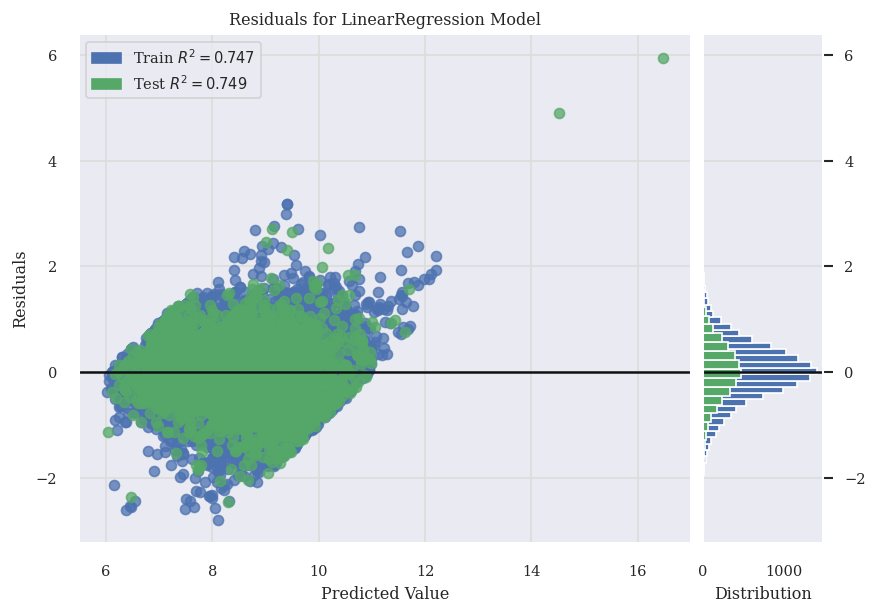

In [ ]:
visualizer = residuals_plot(
    best_lm, X_train, y_train, X_test, y_test,
)

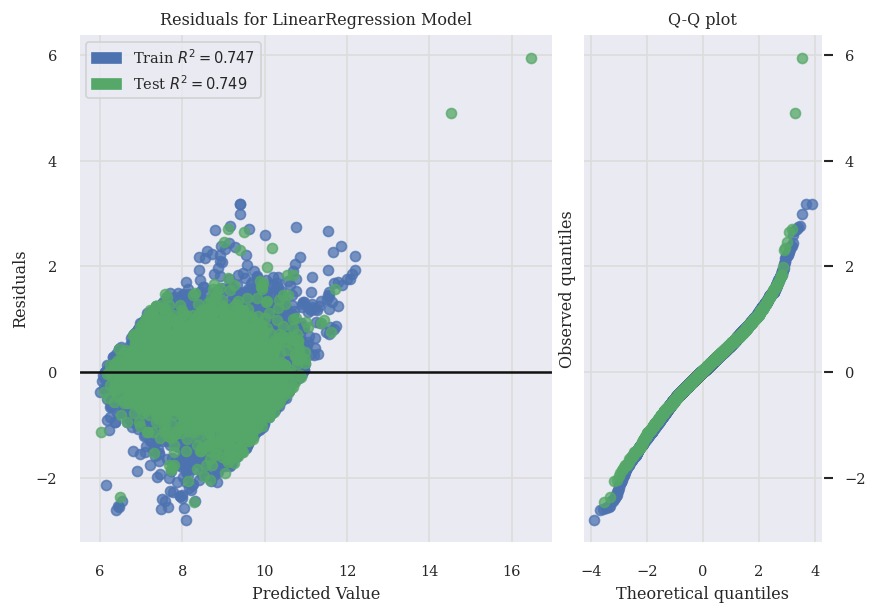

In [ ]:
visualizer = residuals_plot(
    best_lm, X_train, y_train, X_test, y_test, hist=False, qqplot=True
)

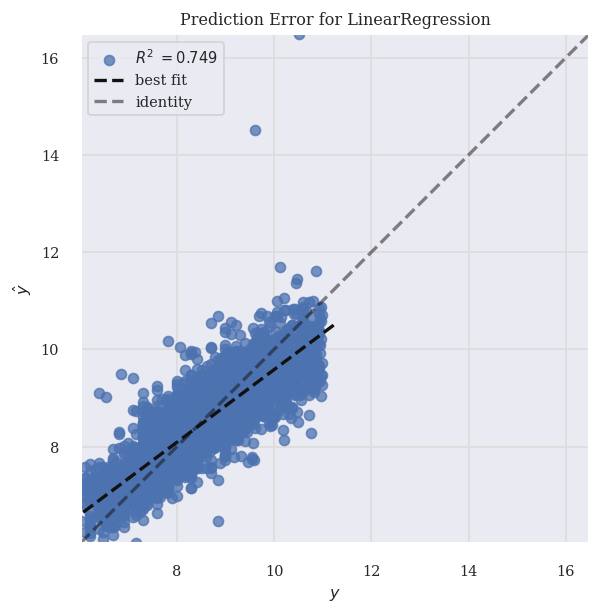

In [ ]:
visualizer = prediction_error(best_lm, X_train, y_train, X_test, y_test)

In [ ]:
# Create a DataFrame with coefficients and feature names
coef_df = pd.DataFrame({'feature': df.drop(['price', 'log1p_price'], axis=1).columns,
                       'coefficient': best_lm.coef_})

# Sort the DataFrame by the absolute value of coefficients
coef_df = coef_df.reindex(coef_df['coefficient'].abs().sort_values(ascending=False).index)

coef_df

,feature,coefficient
30,parking_space,-0.905413
13,amenities_air conditioning,0.522480
36,furnishing_Furnished,0.415740
2,category_Townhouse,0.400719
6,bedrooms,0.334307
34,furnishing_Semi-Furnished,-0.230722
25,amenities_refrigerator,0.220690
12,amenities_24-hour electricity,-0.220450
3,category_Duplex,-0.194405
22,amenities_microwave,0.190659


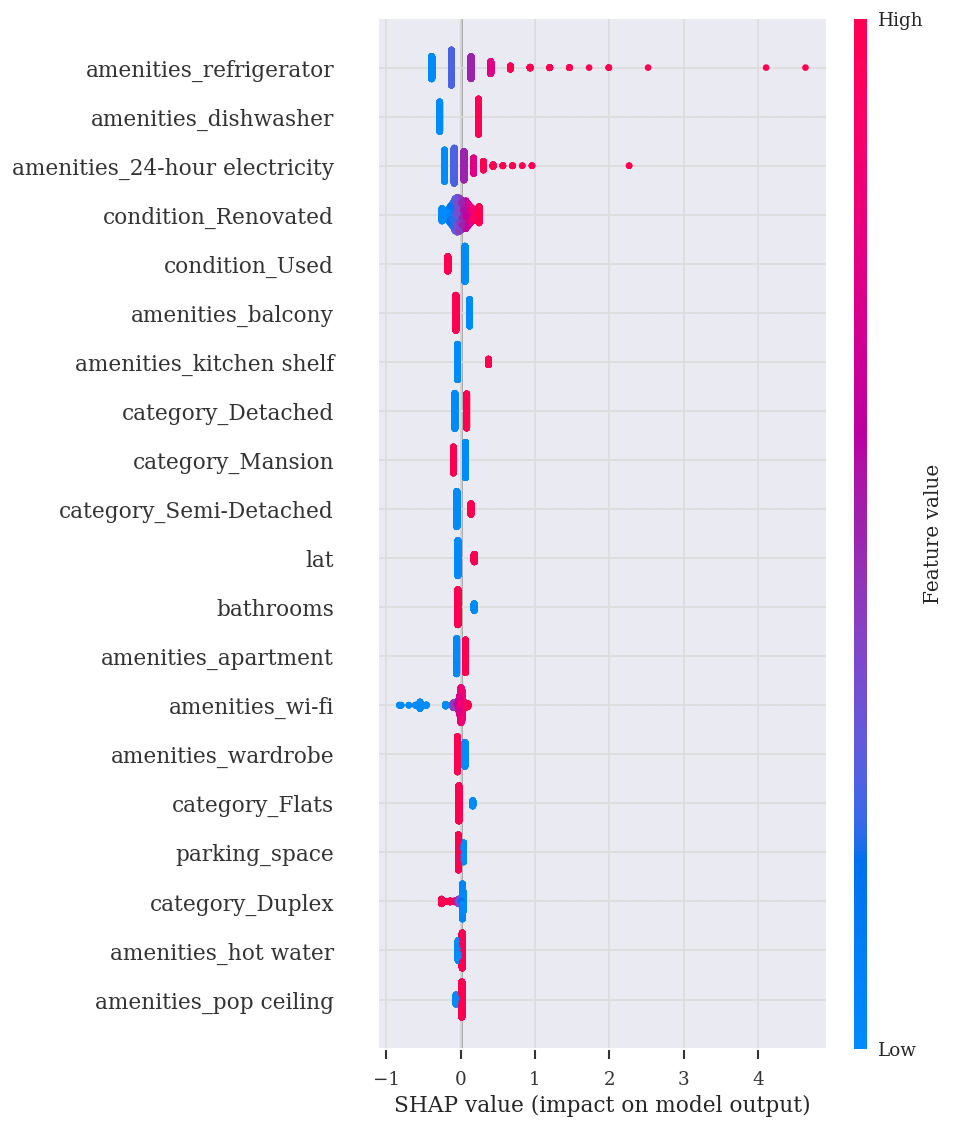

In [ ]:
explainer = shap.Explainer(best_lm, X_train)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=coef_df['feature'].values)

In [ ]:
preds = best_lm.predict(X_test)

In [ ]:
# Reverse the log transformation
actual_preds = np.expm1(preds)
actual_y_test = np.expm1(y_test)

# Compute metrics on the original scale
def compute_metrics_original_scale(y_true, y_pred):
    return pd.DataFrame([{
        "R2": round(metrics.r2_score(y_true, y_pred), 3),
        "mse": round(metrics.mean_squared_error(y_true, y_pred), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), 3),
        "mae": round(metrics.mean_absolute_error(y_true, y_pred), 3),
    }])

val_metrics_original_scale = compute_metrics_original_scale(actual_y_test, actual_preds)
val_metrics_original_scale

,R2,mse,rmse,mae
0,-497.486,5.803304e+10,240900.477,8354.915


In [ ]:
pred_df = pd.DataFrame({"actual": actual_y_test, "pred": actual_preds})
pred_df.head(10)

,actual,pred
0,2000.0,2588.038929
1,2500.0,4773.606627
2,1500.0,1159.594655
3,1000.0,1564.210426
4,4000.0,7562.824933
5,3500.0,4245.691370
6,5000.0,4192.826159
7,3000.0,4461.054291
8,8000.0,14753.130172
9,1200.0,1256.426232


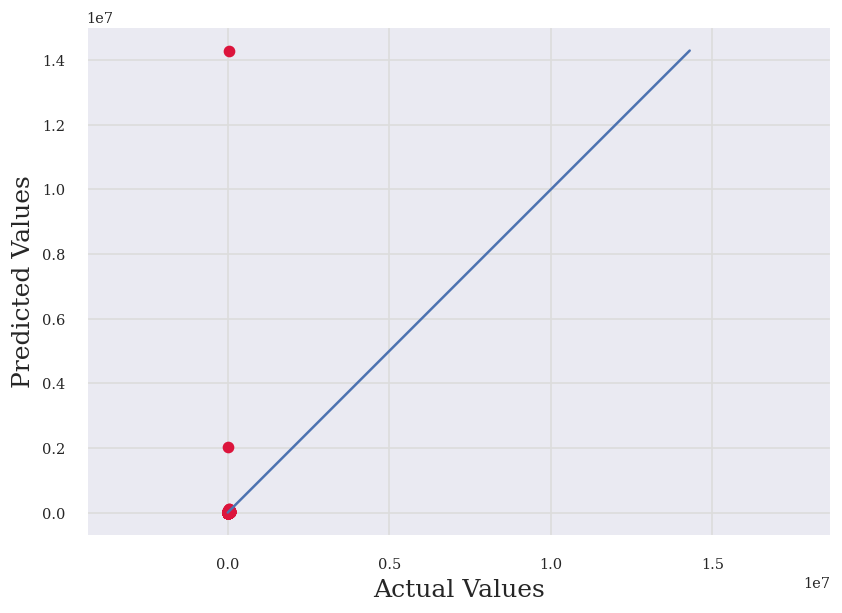

In [ ]:
plt.scatter(pred_df.actual, pred_df.pred, c='crimson')
p1 = max(max(pred_df.actual), max(pred_df.pred))
p2 = min(min(pred_df.actual), min(pred_df.pred))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.axis('equal')
plt.show()

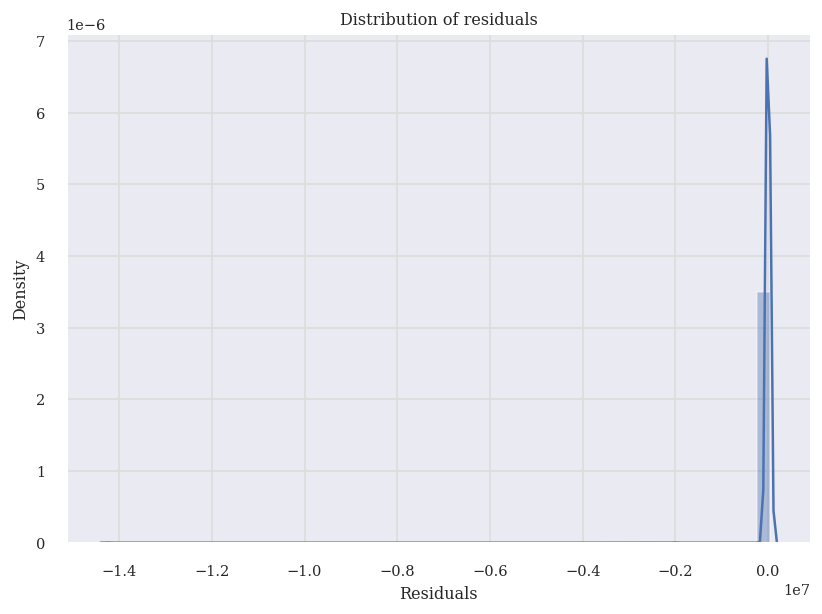

In [ ]:
sns.distplot((pred_df.actual-pred_df.pred))
plt.title('Distribution of residuals')
plt.xlabel("Residuals")
plt.show()